In [1]:
import os
import re
import math
import pickle
import random
import Orange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from humanize import ordinal
from scikit_posthocs import posthoc_nemenyi
from scipy.stats import mannwhitneyu
from scipy.spatial import ConvexHull
from skcriteria import Data, MAX
from skcriteria.madm.closeness import TOPSIS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
DATA_PATH = Path('data')
RESULTS_PATH = DATA_PATH / 'results'
META_FEATURES_PATH = DATA_PATH / 'meta_features'
OUTPUT_PATH = Path('output', 'densenet')

In [3]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
results_dfs = {}
for filename in os.listdir(RESULTS_PATH):
    archtecture = re.search(r'(?<=results_).*(?=.csv)', filename).group()
    results_dfs[archtecture] = pd.read_csv(RESULTS_PATH / filename)

In [5]:
results_df = pd.concat(results_dfs.values(), ignore_index=True)

In [6]:
results_df.head()

,Architecture,Task,Accuracy_vector,Precision_vector,Recall_vector,F1_vector,Accuracy_avg,Precision_avg,Recall_avg,F1_avg
0,ResNet10,airplane-automobile,"[0.942, 0.939, 0.93, 0.9275, 0.916, 0.9315, 0....","[0.9203510204081633, 0.9051657032755298, 0.893...","[0.932, 0.958, 0.948, 0.939, 0.954, 0.938, 0.8...","[0.9414141414141414, 0.9401373895976447, 0.931...",0.92505,0.892683,0.9274,0.925149
1,ResNet10,airplane-bird,"[0.89, 0.889, 0.8935, 0.882, 0.875, 0.8895, 0....","[0.8614113785557986, 0.8492249488752557, 0.852...","[0.847, 0.878, 0.89, 0.886, 0.888, 0.89, 0.887...","[0.8850574712643677, 0.8877654196157735, 0.893...",0.88480,0.843588,0.8753,0.883662
2,ResNet10,airplane-cat,"[0.9245, 0.9325, 0.935, 0.926, 0.932, 0.925, 0...","[0.8897871921182265, 0.8980344995140912, 0.905...","[0.932, 0.947, 0.937, 0.938, 0.961, 0.909, 0.8...","[0.9250620347394541, 0.933464760965993, 0.9351...",0.92580,0.893557,0.9279,0.925876
3,ResNet10,airplane-deer,"[0.9475, 0.9125, 0.943, 0.93, 0.917, 0.936, 0....","[0.9234072781655036, 0.8553790534618757, 0.921...","[0.949, 0.983, 0.933, 0.98, 0.935, 0.928, 0.95...","[0.947578632051922, 0.9182624941616068, 0.9424...",0.93320,0.900529,0.9460,0.934192
4,ResNet10,airplane-dog,"[0.948, 0.9515, 0.936, 0.947, 0.9345, 0.9475, ...","[0.924704, 0.9361238390092881, 0.9224043010752...","[0.948, 0.936, 0.901, 0.95, 0.914, 0.93, 0.955...","[0.948, 0.9507364144235654, 0.9336787564766839...",0.94470,0.923633,0.9363,0.944177


In [7]:
TASKS = results_df['Task'].unique()
ARCHITECTURES = results_df['Architecture'].unique()

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(ARCHITECTURES)

LabelEncoder()

In [9]:
leave_one_out = LeaveOneOut()

In [10]:
metrics_avg = {}
metrics_vectors = {}
for task in TASKS:
    df = results_df.query(f'Task == "{task}"')
    metrics_avg[task] = {}
    metrics_vectors[task] = {}
    for _, row in df.iterrows():
        metrics_avg[task][row['Architecture']] = {
            'accuracy': row['Accuracy_avg'],
            'precision': row['Precision_avg'],
            'recall': row['Recall_avg'],
            'f1': row['F1_avg']
        }
        metrics_vectors[task][row['Architecture']] = {
            'accuracy': np.array(eval(row['Accuracy_vector'])),
            'precision': np.array(eval(row['Precision_vector'])),
            'recall': np.array(eval(row['Recall_vector'])),
            'f1': np.array(eval(row['F1_vector']))
        }

In [11]:
ranking_architectures = {}
for task in TASKS:
    metrics_columns = ['Accuracy_avg', 'Precision_avg', 'Recall_avg', 'F1_avg']
    metrics_df = results_df.query(f'Task == "{task}"')[metrics_columns]
    data = Data(metrics_df.to_numpy(), criteria=[MAX, MAX, MAX, MAX])
    topsis = TOPSIS()
    ranking_architectures[task] = results_df.iloc[
        metrics_df.index[np.argsort(topsis.decide(data).rank_)]
    ]['Architecture'].tolist()

In [12]:
best_architectures = [
    ranking_architectures[task][0]
    for task in TASKS
]

In [13]:
y = label_encoder.transform(best_architectures)

In [14]:
def load_meta_features(feature_extractor_name: str) -> np.ndarray:
    meta_features = []
    for task in TASKS:
        filename = task + '.pkl'
        with open(META_FEATURES_PATH / feature_extractor_name / filename, 'rb') as f:
            meta_features.append(pickle.load(f))
    return np.array(meta_features)

In [15]:
handcraft_X = load_meta_features('handcraft')

In [16]:
densenet_X = load_meta_features('densenet')

In [17]:
def make_dataset_map_plot(X, y):

    def encircle(i, j, ax=None, **kw):
        if not ax:
            ax = plt.gca()
        p = np.c_[i, j]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices, :], **kw)
        ax.add_patch(poly)

    lda = LinearDiscriminantAnalysis(n_components=2)

    component_x, component_y = lda.fit_transform(X, y).T

    g = sns.scatterplot(component_x, component_y, hue=y, style=y)
    g.legend(fontsize='x-small', frameon=False)

    for label, color in zip(np.unique(y), ('r', 'g', 'y', 'b')):
        index = np.where(label == pd.Series(y))
        encircle(
            component_x[index],
            component_y[index],
            ec=color,
            fc=color,
            alpha=0.15
        )

    plt.savefig(OUTPUT_PATH / 'datasets_map.png', dpi=1200, bbox_inches='tight')
    plt.show()

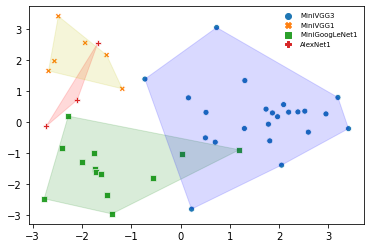

In [18]:
make_dataset_map_plot(densenet_X, best_architectures)

In [19]:
%%time

gt_recommendations = dict(zip(TASKS, best_architectures))

CPU times: user 18 µs, sys: 1 µs, total: 19 µs
Wall time: 23.4 µs


In [20]:
%%time

handcraft_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_rf_recommendations[task] = recommended_architecture

CPU times: user 7.75 s, sys: 23.9 ms, total: 7.77 s
Wall time: 7.78 s


In [21]:
%%time

densenet_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(densenet_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(densenet_X[test_index])
    )[0]
    densenet_rf_recommendations[task] = recommended_architecture

CPU times: user 9.4 s, sys: 23.9 ms, total: 9.42 s
Wall time: 9.42 s


In [22]:
%%time

handcraft_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_knn_recommendations[task] = recommended_architecture

CPU times: user 67.3 ms, sys: 80 µs, total: 67.4 ms
Wall time: 87.6 ms


In [23]:
%%time

densenet_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(densenet_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(densenet_X[test_index])
    )[0]
    densenet_knn_recommendations[task] = recommended_architecture

CPU times: user 105 ms, sys: 18 µs, total: 105 ms
Wall time: 103 ms


In [24]:
%%time

oner_recommendations = []
for _ in range(10):
    recommended_architecture = random.choice(ARCHITECTURES)
    oner_recommendations.append({
        task: recommended_architecture
        for task in TASKS
    })

CPU times: user 106 µs, sys: 0 ns, total: 106 µs
Wall time: 109 µs


In [25]:
%%time

random_recommendations = []
for _ in range(10):
    random_recommendations.append({
        task: random.choice(ARCHITECTURES)
        for task in TASKS
    })

CPU times: user 643 µs, sys: 0 ns, total: 643 µs
Wall time: 649 µs


In [26]:
def make_results(recommendations):
    results = {}
    for task in TASKS:
        best_architecture = ranking_architectures[task][0]
        worst_architecture = ranking_architectures[task][-1]
        recommended_architecture = recommendations[task]
        results[task] = {
            'Ranking_architectures': ', '.join(ranking_architectures[task]),
            'Recommendation_rank': ordinal(ranking_architectures[task].index(recommended_architecture) + 1),
            'P_value[best]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][best_architecture]['accuracy']
            )[1],
            'P_value[worst]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][worst_architecture]['accuracy']
            )[1],
            'Architecture[recommended]': recommended_architecture,
            'Architecture[best]': best_architecture,
            'Architecture[worst]': worst_architecture,
            'Accuracy_avg[recommended]': metrics_avg[task][recommended_architecture]['accuracy'],
            'Accuracy_avg[best]': metrics_avg[task][best_architecture]['accuracy'],
            'Accuracy_avg[worst]': metrics_avg[task][worst_architecture]['accuracy'],
            'Precision_avg[recommended]': metrics_avg[task][recommended_architecture]['precision'],
            'Precision_avg[best]': metrics_avg[task][best_architecture]['precision'],
            'Precision_avg[worst]': metrics_avg[task][worst_architecture]['precision'],
            'Recall_avg[recommended]': metrics_avg[task][recommended_architecture]['recall'],
            'Recall_avg[best]': metrics_avg[task][best_architecture]['recall'],
            'Recall_avg[worst]': metrics_avg[task][worst_architecture]['recall'],
            'F1_avg[recommended]': metrics_avg[task][recommended_architecture]['f1'],
            'F1_avg[best]': metrics_avg[task][best_architecture]['f1'],
            'F1_avg[worst]': metrics_avg[task][worst_architecture]['f1']
        }
    return results

In [27]:
gt_results = make_results(gt_recommendations)
handcraft_rf_results = make_results(handcraft_rf_recommendations)
handcraft_knn_results = make_results(handcraft_knn_recommendations)
densenet_rf_results = make_results(densenet_rf_recommendations)
densenet_knn_results = make_results(densenet_knn_recommendations)

In [28]:
gt_results_df = pd.DataFrame(gt_results).T.rename_axis('Task').reset_index()
handcraft_rf_results_df = pd.DataFrame(handcraft_rf_results).T.rename_axis('Task').reset_index()
handcraft_knn_results_df = pd.DataFrame(handcraft_knn_results).T.rename_axis('Task').reset_index()
densenet_rf_results_df = pd.DataFrame(densenet_rf_results).T.rename_axis('Task').reset_index()
densenet_knn_results_df = pd.DataFrame(densenet_knn_results).T.rename_axis('Task').reset_index()

In [29]:
oner_results_10_executions = [
    make_results(recommendations)
    for recommendations in oner_recommendations
]

In [30]:
random_results_10_executions = [
    make_results(recommendations)
    for recommendations in random_recommendations
]

In [31]:
oner_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in oner_results_10_executions
], ignore_index=True)

In [32]:
random_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in random_results_10_executions
], ignore_index=True)

In [33]:
gt_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",1st,0.484868,9.13359e-05,MiniVGG1,MiniVGG1,ResNet10,0.91925,0.91925,0.8848,0.878482,0.878482,0.843588,0.9418,0.9418,0.8753,0.921148,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [34]:
gt_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    45
Name: Task, dtype: int64

In [35]:
gt_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [36]:
gt_results_df.groupby('Architecture[best]').Task.count()

Architecture[best]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [37]:
gt_results_df.groupby('Architecture[worst]').Task.count()

Architecture[worst]
AlexNet1            1
MiniVGG1            4
ResNet10            6
SmallSqueezeNet    34
Name: Task, dtype: int64

In [38]:
handcraft_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [39]:
handcraft_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    19
2nd    14
3rd     5
4th     5
6th     2
Name: Task, dtype: int64

In [40]:
handcraft_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1    12
MiniVGG1           5
MiniVGG3          28
Name: Task, dtype: int64

In [41]:
densenet_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",5th,9.13359e-05,0.0928556,MiniVGG1,MiniGoogLeNet1,SmallSqueezeNet,0.89945,0.96365,0.91945,0.836805,0.945979,0.89732,0.9932,0.9657,0.8919,0.908942,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",3rd,0.136428,0.00158141,MiniGoogLeNet1,MiniVGG3,ResNet10,0.9656,0.96305,0.95595,0.95172,0.934987,0.937775,0.961,0.9913,0.9518,0.964927,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [42]:
densenet_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    16
2nd    15
3rd    10
4th     3
5th     1
Name: Task, dtype: int64

In [43]:
densenet_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1    11
MiniVGG1           4
MiniVGG3          30
Name: Task, dtype: int64

In [44]:
handcraft_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0651403,0.0186382,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9396,0.94775,0.8408,0.919533,0.915364,0.816722,0.927,0.9735,0.94,0.938489,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [45]:
handcraft_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    16
2nd    17
3rd     7
4th     5
Name: Task, dtype: int64

In [46]:
handcraft_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1    15
MiniVGG1           1
MiniVGG3          28
Name: Task, dtype: int64

In [47]:
densenet_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",4th,0.0319611,9.08256e-05,AlexNet1,MiniVGG1,ResNet10,0.91105,0.91925,0.8848,0.87307,0.878482,0.843588,0.9188,0.9418,0.8753,0.911862,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",5th,9.13359e-05,0.0928556,MiniVGG1,MiniGoogLeNet1,SmallSqueezeNet,0.89945,0.96365,0.91945,0.836805,0.945979,0.89732,0.9932,0.9657,0.8919,0.908942,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",3rd,0.136428,0.00158141,MiniGoogLeNet1,MiniVGG3,ResNet10,0.9656,0.96305,0.95595,0.95172,0.934987,0.937775,0.961,0.9913,0.9518,0.964927,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",2nd,0.324704,0.000743288,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.9746,0.97695,0.90715,0.959649,0.961333,0.890751,0.9831,0.9875,0.8509,0.975034,0.977209,0.856313


In [48]:
densenet_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    15
2nd    15
3rd     7
4th     7
5th     1
Name: Task, dtype: int64

In [49]:
densenet_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           2
MiniGoogLeNet1    17
MiniVGG1           4
MiniVGG3          22
Name: Task, dtype: int64

In [50]:
oner_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",3rd,0.0154145,0.171989,MiniVGG1,MiniGoogLeNet1,AlexNet1,0.97565,0.9813,0.97055,0.972557,0.974671,0.96372,0.9576,0.9763,0.9552,0.975153,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",4th,0.000571086,0.352676,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.96545,0.9801,0.93615,0.964704,0.976707,0.921241,0.9324,0.9671,0.914,0.964165,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",3rd,0.00220245,0.0407042,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.97085,0.97825,0.92565,0.95764,0.970667,0.896233,0.9706,0.9724,0.9546,0.970888,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",2nd,0.00760796,0.0104219,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9666,0.97565,0.88885,0.955483,0.963455,0.866129,0.957,0.978,0.9128,0.966246,0.975767,0.897996


In [51]:
oner_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    97
2nd    84
3rd    64
4th    72
5th    78
6th    55
Name: Task, dtype: int64

In [52]:
oner_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st    9.7
2nd    8.4
3rd    6.4
4th    7.2
5th    7.8
6th    5.5
Name: Task, dtype: float64

In [53]:
oner_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1            45
MiniGoogLeNet1      45
MiniVGG1            90
MiniVGG3           135
ResNet10            90
SmallSqueezeNet     45
Name: Task, dtype: int64

In [54]:
oner_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1            4.5
MiniGoogLeNet1      4.5
MiniVGG1            9.0
MiniVGG3           13.5
ResNet10            9.0
SmallSqueezeNet     4.5
Name: Task, dtype: float64

In [55]:
random_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",5th,0.00029003,0.128241,SmallSqueezeNet,MiniVGG1,ResNet10,0.89055,0.91925,0.8848,0.850013,0.878482,0.843588,0.8882,0.9418,0.8753,0.889767,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",4th,0.00109688,0.236338,ResNet10,MiniVGG3,SmallSqueezeNet,0.9258,0.95015,0.9046,0.893557,0.920075,0.872486,0.9279,0.9716,0.8927,0.925876,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",5th,0.00159282,0.469815,SmallSqueezeNet,MiniVGG3,ResNet10,0.9428,0.963,0.9447,0.911598,0.945098,0.923633,0.962,0.9663,0.9363,0.944186,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",2nd,0.0187099,0.0517295,MiniVGG3,MiniGoogLeNet1,AlexNet1,0.97725,0.9813,0.97055,0.971923,0.974671,0.96372,0.9655,0.9763,0.9552,0.976912,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",4th,0.000571086,0.352676,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.96545,0.9801,0.93615,0.964704,0.976707,0.921241,0.9324,0.9671,0.914,0.964165,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",3rd,0.00220245,0.0407042,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.97085,0.97825,0.92565,0.95764,0.970667,0.896233,0.9706,0.9724,0.9546,0.970888,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",3rd,0.0800373,0.00156438,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96465,0.97565,0.88885,0.952876,0.963455,0.866129,0.9543,0.978,0.9128,0.963514,0.975767,0.897996


In [56]:
random_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    65
2nd    77
3rd    80
4th    74
5th    74
6th    80
Name: Task, dtype: int64

In [57]:
random_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st    6.5
2nd    7.7
3rd    8.0
4th    7.4
5th    7.4
6th    8.0
Name: Task, dtype: float64

In [58]:
random_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           80
MiniGoogLeNet1     70
MiniVGG1           65
MiniVGG3           69
ResNet10           91
SmallSqueezeNet    75
Name: Task, dtype: int64

In [59]:
random_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1           8.0
MiniGoogLeNet1     7.0
MiniVGG1           6.5
MiniVGG3           6.9
ResNet10           9.1
SmallSqueezeNet    7.5
Name: Task, dtype: float64

In [60]:
algorithms_recommendations_dfs = {
    'GT': gt_results_df,
    'handcraft_RF': handcraft_rf_results_df,
    'densenet_RF': densenet_rf_results_df,
    'handcraft_KNN': handcraft_knn_results_df,
    'densenet_KNN': densenet_knn_results_df,
    'OneR': oner_results_df,
    'Random': random_results_df
}

In [61]:
metrics_dfs = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    metrics_dfs[algorithm] = recommendations_df.groupby('Task').apply(np.mean).reset_index()

In [62]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_mean': np.mean(metrics_df['Accuracy_avg[recommended]']),
        'Accuracy_std': np.std(metrics_df['Accuracy_avg[recommended]']),
        'Precision_mean': np.mean(metrics_df['Precision_avg[recommended]']),
        'Precision_std': np.std(metrics_df['Precision_avg[recommended]']),
        'Recall_mean': np.mean(metrics_df['Recall_avg[recommended]']),
        'Recall_std': np.std(metrics_df['Recall_avg[recommended]']),
        'F1_mean': np.mean(metrics_df['F1_avg[recommended]']),
        'F1_std': np.std(metrics_df['F1_avg[recommended]'])
    }
pd.DataFrame(data).T

,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
GT,0.946940,0.037275,0.923003,0.051634,0.954076,0.038517,0.947482,0.037054
handcraft_RF,0.938064,0.044880,0.914013,0.054077,0.936780,0.074626,0.936590,0.050713
densenet_RF,0.939571,0.044033,0.914798,0.056942,0.943609,0.055398,0.939421,0.046304
handcraft_KNN,0.941791,0.036199,0.917814,0.048808,0.944056,0.042035,0.941651,0.036437
densenet_KNN,0.938850,0.043852,0.914775,0.056732,0.939940,0.056823,0.938256,0.046476
OneR,0.922724,0.049684,0.894733,0.062799,0.926780,0.052146,0.921882,0.050301
Random,0.917228,0.054724,0.889618,0.067311,0.918915,0.057474,0.915292,0.055959


In [63]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(10 if algorithm in {'Random', 'OneR'} else 1)
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,densenet_RF,handcraft_KNN,densenet_KNN,OneR,Random
1st,45.0,19.0,16.0,16.0,15.0,9.7,6.5
2nd,0.0,14.0,15.0,17.0,15.0,8.4,7.7
3rd,0.0,5.0,10.0,7.0,7.0,6.4,8.0
4th,0.0,5.0,3.0,5.0,7.0,7.2,7.4
5th,0.0,0.0,1.0,0.0,1.0,7.8,7.4
6th,0.0,2.0,0.0,0.0,0.0,5.5,8.0


In [64]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(len(recommendations_df))
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,densenet_RF,handcraft_KNN,densenet_KNN,OneR,Random
1st,1.0,0.422222,0.355556,0.355556,0.333333,0.215556,0.144444
2nd,0.0,0.311111,0.333333,0.377778,0.333333,0.186667,0.171111
3rd,0.0,0.111111,0.222222,0.155556,0.155556,0.142222,0.177778
4th,0.0,0.111111,0.066667,0.111111,0.155556,0.160000,0.164444
5th,0.0,0.000000,0.022222,0.000000,0.022222,0.173333,0.164444
6th,0.0,0.044444,0.000000,0.000000,0.000000,0.122222,0.177778


In [65]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_p_value': mannwhitneyu(
            metrics_df['Accuracy_avg[recommended]'],
            metrics_df['Accuracy_avg[best]']
        )[1],
        'Precision_p_value': mannwhitneyu(
            metrics_df['Precision_avg[recommended]'],
            metrics_df['Precision_avg[best]']
        )[1],
        'Recall_p_value': mannwhitneyu(
            metrics_df['Recall_avg[recommended]'],
            metrics_df['Recall_avg[best]']
        )[1],
        'F1_p_value': mannwhitneyu(
            metrics_df['F1_avg[recommended]'],
            metrics_df['F1_avg[best]']
        )[1]
    }
pd.DataFrame(data)

,GT,handcraft_RF,densenet_RF,handcraft_KNN,densenet_KNN,OneR,Random
Accuracy_p_value,0.49839,0.120959,0.137080,0.113811,0.128426,0.001789,0.000573
Precision_p_value,0.49839,0.155571,0.212159,0.180901,0.206358,0.005141,0.002429
Recall_p_value,0.49839,0.245089,0.236300,0.083790,0.112266,0.000383,0.000059
F1_p_value,0.49839,0.116950,0.125903,0.098311,0.109217,0.001238,0.000350


In [66]:
def make_cd(metric):
    algorithms = list(metrics_dfs.keys())
    data = [
        metrics_dfs[algorithm][metric].tolist()
        for algorithm in algorithms
    ]
    result_df = posthoc_nemenyi(data)
    result_df.index, result_df.columns = algorithms, algorithms
    names = algorithms
    avranks = (1 - np.abs(result_df['GT'])) * 5 + 1
    cd = Orange.evaluation.compute_CD(avranks, 45)
    print('cd:', cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd)
    plt.savefig(OUTPUT_PATH / f'cd_{metric}.png', dpi=1200, bbox_inches='tight')
    plt.show()

cd: 1.3427239947686223


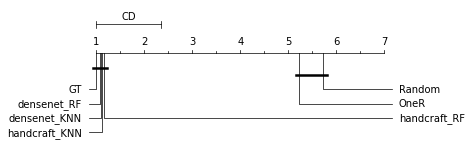

In [67]:
make_cd('Accuracy_avg[recommended]')

cd: 1.3427239947686223


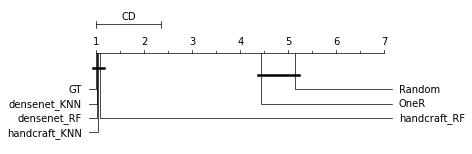

In [68]:
make_cd('Precision_avg[recommended]')

cd: 1.3427239947686223


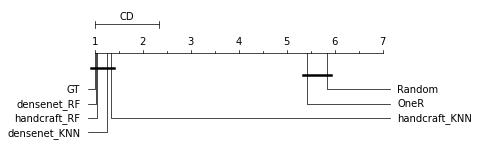

In [69]:
make_cd('Recall_avg[recommended]')

cd: 1.3427239947686223


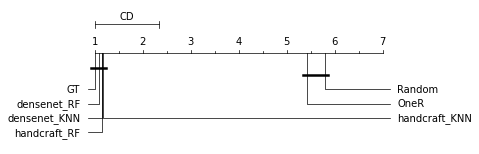

In [70]:
make_cd('F1_avg[recommended]')

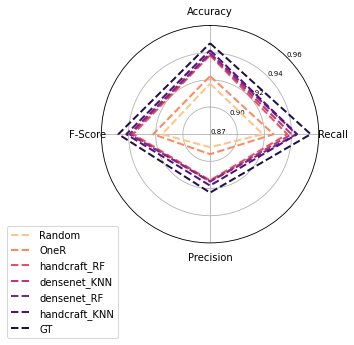

In [71]:
data = {
    'Algorithm': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F-Score': []
}

for algorithm, metrics_df in metrics_dfs.items():
    data['Algorithm'].append(algorithm)
    data['Recall'].append(np.mean(metrics_df['Recall_avg[recommended]']))
    data['Accuracy'].append(np.mean(metrics_df['Accuracy_avg[recommended]']))
    data['F-Score'].append(np.mean(metrics_df['F1_avg[recommended]']))
    data['Precision'].append(np.mean(metrics_df['Precision_avg[recommended]']))

df = pd.DataFrame(data).sort_values(by='Accuracy').reset_index(drop=True)

# ------- PART 1: Create background

# number of variable
categories = list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(45)
plt.yticks([0.88, 0.9, 0.92, 0.94, 0.96], ["0.87", "0.90", "0.92", "0.94", "0.96"], color="black", size=7)
plt.ylim(0.88, 0.96)

# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

colors = sns.color_palette('magma', len(df))

for i in range(len(df)):
    algorithm = df.loc[i]['Algorithm']
    values = df.loc[i].drop('Algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=2,
        linestyle='dashed',
        label=algorithm,
        color=colors.pop()
    )

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig(OUTPUT_PATH / 'radar.png', dpi=1200, bbox_inches='tight')
plt.show()